# Simple RNN

## 定义函数

In [19]:
# 导入需要的库
import io
import os
import unicodedata
import string
import glob

import torch
import random

In [20]:
# alphabet small + capital letters + ".,;'"
ALL_LETTERS = string.ascii_letters + ".,;'"
N_LETTERS = len(ALL_LETTERS)

In [21]:
# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in ALL_LETTERS
    )

In [29]:
def load_data():
    # Build the category_lines dictionary, a list of names per language
    category_lines = {}
    all_categories = []

    def find_files(path):
        return glob.glob(path)

    # Read a file and split into lines
    def read_lines(filename):
        lines = io.open(filename, encoding = 'utf-8').read().strip().split('\n')
        return [unicode_to_ascii(line) for line in lines]

    for filename in find_files('../../resource/course_data/names/*.txt'):
        category = os.path.splitext(os.path.basename(filename))[0]
        all_categories.append(category)

        lines = read_lines(filename)
        category_lines[category] = lines

    return category_lines, all_categories


To represent a single letter, we use a “one-hot vector” of  size <1 x n_letters>. A one-hot vector is filled with 0s except for a 1 at index of the current letter, e.g. "b" = <0 1 0 0 0 ...>.

To make a word we join a bunch of those into a 2D matrix <line_length x 1 x n_letters>.

That extra 1 dimension is because PyTorch assumes everything is in batches - we’re just using a batch size of 1 here.

In [23]:
# Find letter index from all_letters, e.g. "a" = 0
def letter_to_index(letter):
    return ALL_LETTERS.find(letter)

In [24]:
# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letter_to_tensor(letter):
    tensor = torch.zeros(1, N_LETTERS)
    tensor[0][letter_to_index(letter)] = 1
    return tensor

In [25]:
# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors

def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, N_LETTERS)
    for i, letter in enumerate(line):
        tensor[i][0][letter_to_index(letter)] = 1
    return tensor

In [26]:
def random_training_example(category_lines, all_categories):
    def random_choice(a):
        random_idx = random.randint(0, len(a) - 1)
        return a[random_idx]

    category = random_choice(all_categories)
    line = random_choice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype = torch.long)
    line_tensor = line_to_tensor(line)
    return category, line, category_tensor, line_tensor

In [30]:
if __name__ == '__main__':
    print(ALL_LETTERS)
    print(unicode_to_ascii('Ślusàrski'))

    category_lines, all_categories = load_data()
    print(category_lines['Italian'][:5])

    print(letter_to_tensor('J'))  # [1, 57]
    print(line_to_tensor('Jones').size())  # [5, 1, 57]

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ.,;'
Slusarski
['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])
torch.Size([5, 1, 56])


# Main

In [31]:
# 导入需要的库
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [34]:
class RNN(nn.Module):
    # implement RNN from scratch rather than using nn.RNN
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim = 1)

    def forward(self, input_tensor, hidden_tensor):
        combined = torch.cat((input_tensor, hidden_tensor), 1)

        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

category_lines, all_categories = load_data()
n_categories = len(all_categories)

n_hidden = 128
rnn = RNN(N_LETTERS, n_hidden, n_categories)

# one step
input_tensor = letter_to_tensor('A')
hidden_tensor = rnn.init_hidden()

output, next_hidden = rnn(input_tensor, hidden_tensor)
print(output.size())
print(next_hidden.size())


torch.Size([1, 18])
torch.Size([1, 128])


In [36]:
# whole sequence/name
input_tensor = line_to_tensor('Albert')
hidden_tensor = rnn.init_hidden()

output, next_hidden = rnn(input_tensor[0], hidden_tensor)
print(output.size())
print(next_hidden.size())

torch.Size([1, 18])
torch.Size([1, 128])


In [37]:
def category_from_output(output):
    category_idx = torch.argmax(output).item()
    return all_categories[category_idx]

In [38]:
print(category_from_output(output))

German


In [39]:
criterion = nn.NLLLoss()
learning_rate = 0.005
optimizer = torch.optim.SGD(rnn.parameters(), lr = learning_rate)

In [40]:
def train(line_to_tensor, category_tensor):
    hidden = rnn.init_hidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_to_tensor[i], hidden)
    
    loss = criterion(output, category_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return output, loss.item()

In [41]:
current_loss = 0
all_losses = []
plot_steps, print_steps = 1000, 5000
n_iters = 100000

In [43]:
for i in range(n_iters):
    category, line, category_tensor, line_tensor = random_training_example(category_lines, all_categories)

    output, loss = train(line_tensor, category_tensor)
    current_loss += loss

    if (i + 1) % plot_steps == 0:
        all_losses.append(current_loss / plot_steps)
        current_loss = 0

    if (i + 1) % print_steps == 0:
        guess = category_from_output(output)
        corrent = 'CORRECT' if guess == category else f'WRONG ({category})'
        print(f'{i+1} {(i+1) / n_iters *100} {loss:.4f} {line} / {guess} {corrent}')

5000 5.0 2.5063 Bureau / Scottish WRONG (French)
10000 10.0 1.4726 Bitar / Arabic CORRECT
15000 15.0 1.9405 Bazilevitch / Russian CORRECT
20000 20.0 1.5565 Dupont / French CORRECT
25000 25.0 0.1202 Majewski / Polish CORRECT
30000 30.0 1.1579 Kucharova / Czech CORRECT
35000 35.0 1.0075 Sheng / Chinese CORRECT
40000 40.0 0.8343 Masih / Arabic CORRECT
45000 45.0 0.5371 Fan / Chinese CORRECT
50000 50.0 0.3260 Vinh / Vietnamese CORRECT
55000 55.00000000000001 2.5464 Pahlke / Polish WRONG (German)
60000 60.0 1.5921 Clark / Scottish CORRECT
65000 65.0 4.3648 Paulis / Greek WRONG (Dutch)
70000 70.0 1.3289 Thian / Vietnamese WRONG (Chinese)
75000 75.0 2.2715 Kelly / English WRONG (Irish)
80000 80.0 1.0069 Siu / Korean WRONG (Chinese)
85000 85.0 0.8168 Kan / Chinese CORRECT
90000 90.0 0.2283 Dinh / Vietnamese CORRECT
95000 95.0 2.0048 Abbascia / Japanese WRONG (Italian)
100000 100.0 0.6310 O'Shea / Irish CORRECT


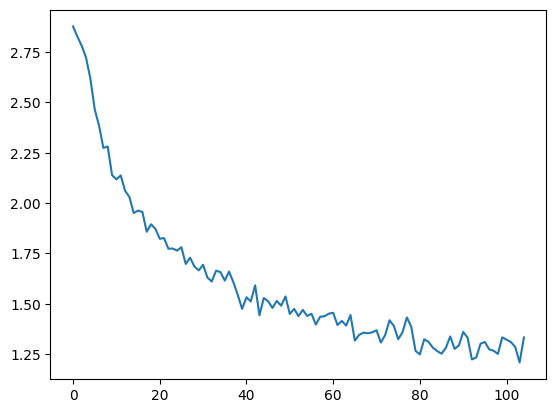

In [44]:
plt.figure()
plt.plot(all_losses)
plt.show()

In [45]:
def predict(input_line):
    print(f'\n > {input_line}')
    with torch.no_grad():
        line_tensor = line_to_tensor(input_line)

        hidden = rnn.init_hidden()

        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)

        guess = category_from_output(output)
        print(guess)

In [46]:
while True:
    sentence = input('Input: ')
    if sentence == 'quit':
        break
    predict(sentence)